## t1

In [24]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
# plt.rcParams['axes.unicode_minus'] = False    # 解决保存图像是负号'-'显示为方块的问题

# --- 1. 数据加载 ---
df = pd.read_excel('表1 (Table 1).xlsx', header=0)
# pd.read_csv(file_path, header=None)
# 假设车流量数据在第一列 (索引为 0)
F_observed = df.iloc[:, 2].values


# 检查数据点数量是否为60
if len(F_observed) != 60:
    print(f"错误：预期有60个数据点，但从文件中读取到 {len(F_observed)} 个。")
    print("请检查输入文件 '表1 (Table 1).xlsx - 表1 (Table 1).csv' 的格式和内容。")
    print("数据应包含从 7:00 到 8:58 每两分钟的主路车流量，共60行。")
    exit()



In [10]:
# 时间点 t = 0, 1, ..., 59
t_data = np.arange(len(F_observed))

# --- 2. 定义拟合模型 ---
# total_flow 函数需要返回给定参数下的总预测流量 F_predicted(t) = f1(t) + f2(t)
def total_flow(t, a, b, c, d, e, tp_float):
    """
    计算总流量模型 F(t) = f1(t) + f2(t)。
    f1(t) = a*t + b
    f2(t) = ct + d if t <= tp else et + g
    其中 g = (c - e) * tp + d (确保连续性)
    tp_float 用于优化，内部转换为整数 tp。
    """
    # 将 tp_float 转换为整数索引，并限制在有效范围内 [0, 58]
    # (峰值不能是最后一个点，否则下降段没有意义)
    tp = int(round(tp_float))
    tp = max(0, min(len(t_data) - 2, tp)) # 确保 tp <= 58

    # 支路1 流量
    f1 = a * t + b

    # 支路2 流量 (分段定义)
    # 计算 g 以保证连续性
    g = (2 * c) * tp + d
    # 使用 np.where 实现分段
    f2 = np.where(t <= tp, c * t + d, -c * t + g)

    # 总流量
    F_predicted = f1 + f2

    # 添加惩罚项，如果流量为负，使其远离该解（虽然bounds应处理大部分情况）
    penalty = np.sum(np.maximum(0, -f1)**2) + np.sum(np.maximum(0, -f2)**2)

    return F_predicted + penalty * 1e6 # 增加大的惩罚使优化器避免负流量



In [20]:
# --- 3. 参数优化 (curve_fit) ---

# 参数初始猜测值 (p0)
# a: f1 斜率 (正)
# b: f1 截距 (正，初始流量)
# c: f2 增长斜率 (正)
# d: f2 截距 (正，初始流量)
# e: f2 下降斜率 (负)
# tp_float: 峰值时间 (0-58 之间)
initial_guess = [
    0.5, F_observed[0] * 0.5,  # a, b (假设f1占初始流量30%)
    1, F_observed[0] * 0.5,  # c, d (假设f2占初始流量70%)
    -1,                      # e
    len(t_data) / 2          # tp_float (假设峰值在中间)
]

# 参数边界 (bounds)
# (lower bounds), (upper bounds)
bounds = (
    [0, 0, 0, 0, -np.inf, 0],  # Lower bounds: a>=0, b>=0, c>=0, d>=0, e任意但倾向<0, tp>=0
    [np.inf, np.inf, np.inf, np.inf, 0, len(t_data) - 2] # Upper bounds: a,b,c,d无上限, e<=0, tp<=58
)

# 执行拟合
try:
    params, covariance = curve_fit(
        total_flow,
        t_data,
        F_observed,
        p0=initial_guess,
        bounds=bounds,
        maxfev=10000 # 增加最大函数评估次数
    )
except RuntimeError as e:
    print(f"优化未收敛: {e}")
    print("尝试调整初始猜测值或边界。")
    # 可以尝试不加边界，但可能得到物理意义不符的解
    # params, covariance = curve_fit(total_flow, t_data, F_observed, p0=initial_guess, maxfev=10000)



In [21]:
# --- 4. 提取结果和定义函数 ---
# 提取优化后的参数
a_opt, b_opt, c_opt, d_opt, e_opt, tp_float_opt = params
tp_opt = int(round(tp_float_opt))
tp_opt = max(0, min(len(t_data) - 2, tp_opt)) # 再次确保范围

# 计算 g_opt
g_opt = (c_opt - e_opt) * tp_opt + d_opt

# 定义最终的支路流量函数
def f1(t):
    return a_opt * t + b_opt

def f2(t):
    # 使用 np.where 处理 t 是单个值或数组的情况
    return np.where(t <= tp_opt, c_opt * t + d_opt, e_opt * t + g_opt)

# 检查流量是否为负
f1_vals = f1(t_data)
f2_vals = f2(t_data)
if np.any(f1_vals < 0) or np.any(f2_vals < 0):
    print("\n警告：拟合得到的流量函数在某些时间点产生负值。")
    print("这可能意味着模型假设或数据与实际情况存在偏差，或者优化结果不是最优。")
    print(f"f1 最小值: {np.min(f1_vals):.2f}")
    print(f"f2 最小值: {np.min(f2_vals):.2f}")

In [22]:
# --- 5. 输出结果 ---

print("\n--- 优化结果 ---")
print(f"最优参数:")
print(f"  a (f1 斜率): {a_opt:.4f}")
print(f"  b (f1 截距): {b_opt:.4f}")
print(f"  c (f2 增长斜率): {c_opt:.4f}")
print(f"  d (f2 截距): {d_opt:.4f}")
print(f"  e (f2 下降斜率): {e_opt:.4f}")
print(f"  tp (f2 峰值时间索引): {tp_opt}")
print(f"  g (计算得到): {g_opt:.4f}") # g 是衍生参数


--- 优化结果 ---
最优参数:
  a (f1 斜率): 0.5000
  b (f1 截距): 3.5000
  c (f2 增长斜率): 1.0000
  d (f2 截距): 3.5000
  e (f2 下降斜率): -1.0000
  tp (f2 峰值时间索引): 30
  g (计算得到): 63.5000


  支路2 流量峰值大约出现在 t=30 (对应时间 7:00 + 60 分钟 = 08:00)

--- 支路流量函数 (t=0 对应 7:00, t=59 对应 8:58) ---
支路1: f1(t) = 0.5000 * t + 3.5000
支路2: f2(t) = 
  if 0 <= t <= 30: 1.0000 * t + 3.5000
  if 30 < t <= 59: -1.0000 * t + 63.5000


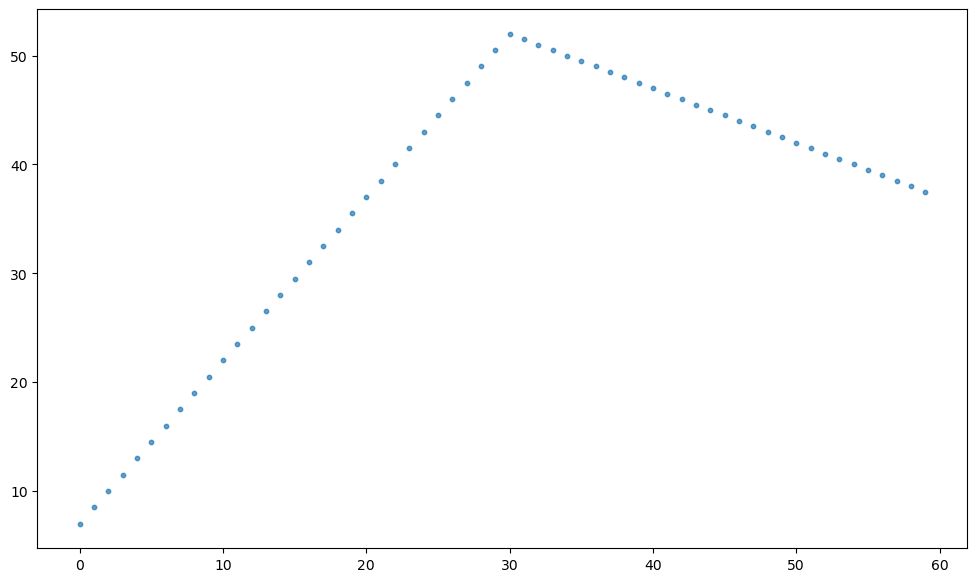

In [ ]:
# 换算回实际时间
peak_time_minutes = tp_opt * 2 # 每个索引代表2分钟
peak_hour = 7 + peak_time_minutes // 60
peak_minute = peak_time_minutes % 60
print(f"  支路2 流量峰值大约出现在 t={tp_opt} (对应时间 7:00 + {peak_time_minutes} 分钟 = {peak_hour:02d}:{peak_minute:02d})")

print("\n--- 支路流量函数 (t=0 对应 7:00, t=59 对应 8:58) ---")
print(f"支路1: f1(t) = {a_opt:.4f} * t + {b_opt:.4f}")
print(f"支路2: f2(t) = ")
print(f"  if 0 <= t <= {tp_opt}: {c_opt:.4f} * t + {d_opt:.4f}")
print(f"  if {tp_opt} < t <= 59: {e_opt:.4f} * t + {g_opt:.4f}")

# --- 6. 可视化 (可选) ---
plt.figure(figsize=(12, 7))
plt.scatter(t_data, F_observed, label='观测总流量 F(t)', marker='o', s=10, alpha=0.7)

# 计算拟合的流量
F_predicted = total_flow(t_data, *params) # 使用未舍入的tp计算拟合曲线可能更平滑
f1_predicted = f1(t_data)
f2_predicted = f2(t_data)